In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import math
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import bisect

cosmo = FlatLambdaCDM(H0=72, Om0=0.3)

In [3]:
hdulist = fits.open('../petroC_nsa_gzoo.fits')
tbdata = hdulist[1].data
color = tbdata['col10'] #^{0.1}(g-r), K-E corrected to z=0.1, petro
M_r = tbdata['col9'] #^{0.1}(M_r) - 5\log h, K-E corrected to z=0.1, petro
pfeatures = tbdata['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
psmooth = tbdata['t01_smooth_or_features_a01_smooth_weighted_fraction']
sSFR = tbdata['B300']
HA = tbdata['HAFLUX']
HB = tbdata['HBFLUX']
O3 = tbdata['O3FLUX']
N2 = tbdata['N2FLUX']
D4000 = tbdata['D4000']
z = tbdata['Z']
hdulist.close()

In [4]:
D4000_bins, SSFR_bins, Errs = np.load('../Dn4000Params_final.npy')

In [5]:
early_pfeatures = []
early_psmooth = []
early_color = []
early_sfr = []
early_mr = []

late_pfeatures = []
late_psmooth = []
late_color = []
late_sfr = []
late_mr = []

int_pfeatures = []
int_psmooth = []
int_color = []
int_sfr = []
int_mr = []

LHA_arr = []
LHB_arr = []
LN2_arr = []
LO3_arr = []

for i in np.arange(pfeatures.size):
    if z[i] > 0.01 and z[i] < 0.06 and HA[i] > 0 and HB[i] > 0:
        color_line = 0.7 - 0.032*(M_r[i] + 16.5)
        active_line = -10 + 0.094*(M_r[i] + 15)
    
        #Convert fluxes to luminosities
        FHA = HA[i]*(1e-17)*u.erg / u.s / u.cm**2
        FHA = FHA.to(u.W/(u.pc**2))
        LHA = cosmo.luminosity_distance(z[i]).to(u.pc)**2 * 4 * math.pi * FHA
        LHA_arr.append(LHA.value)
        
        FHB = HB[i]*(1e-17)*u.erg / u.s / u.cm**2
        FHB = FHB.to(u.W/(u.pc**2))
        LHB = cosmo.luminosity_distance(z[i]).to(u.pc)**2 * 4 * math.pi * FHB
        LHB_arr.append(LHB.value)
        
        FO3 = O3[i]*(1e-17)*u.erg / u.s / u.cm**2
        FO3 = FO3.to(u.W/(u.pc**2))
        LO3 = cosmo.luminosity_distance(z[i]).to(u.pc)**2 * 4 * math.pi * FO3
        LO3_arr.append(LO3.value)
        
        FN2 = N2[i]*(1e-17)*u.erg / u.s / u.cm**2
        FN2 = FN2.to(u.W/(u.pc**2))
        LN2 = cosmo.luminosity_distance(z[i]).to(u.pc)**2 * 4 * math.pi * FN2
        LN2_arr.append(LN2.value)
        
        if LHA > 0 and LHB > 0 and LO3 > 0 and LN2 > 0:
            O3_BPT = math.log(LO3/LHB,10)
            N2_BPT = math.log(LN2/LHA,10)
            if O3_BPT > 0.61/(N2_BPT - 0.05) + 1.3 or N2_BPT > -0.2: #galaxies that lie above Kauffman BPT line
                sfr_ind = bisect.bisect_left(D4000_bins, D4000[i])-1
                logsSFR = SSFR_bins[sfr_ind]
            else:
                LHA_c = LHA*(((LHA/LHB)/2.8)**2.36) #corrected HA luminosity from Spindler et. al. 2017
                logsSFR = math.log(LHA_c.value, 10) - 41.1 #SFR calculated using Halpha flux from Spindler et al 2017
            if color[i] >= color_line: #red galaxies
                if logsSFR <= active_line: #passive galaxies - early type
                    early_pfeatures.append(pfeatures[i])
                    early_psmooth.append(psmooth[i])
                    early_color.append(color[i])
                    early_sfr.append(logsSFR)
                    early_mr.append(M_r[i])
                else: #red and active - intermediate type
                    int_pfeatures.append(pfeatures[i])
                    int_psmooth.append(pfeatures[i])
                    int_color.append(color[i])
                    int_sfr.append(logsSFR)
                    int_mr.append(M_r[i])
            elif logsSFR >= active_line: #blue and active - late type
                late_pfeatures.append(pfeatures[i])
                late_psmooth.append(psmooth[i])
                late_color.append(color[i])
                late_sfr.append(logsSFR)
                late_mr.append(M_r[i])

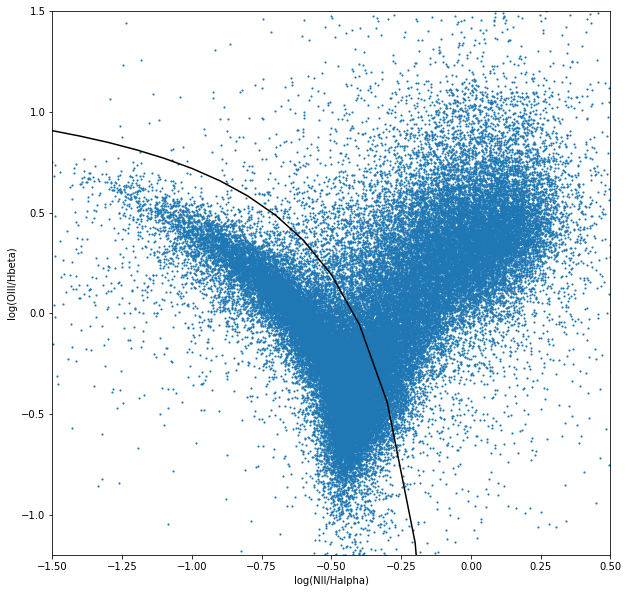

In [6]:
fig2 = plt.figure(figsize=(10,10))

O3HB = []
N2HA = []
for i in np.arange(len(LO3_arr)):
    if LO3_arr[i] > 0 and LHB_arr[i] > 0 and LN2_arr[i] > 0 and LHA_arr[i] > 0:
        O3HB.append(math.log(LO3_arr[i]/LHB_arr[i], 10))
        N2HA.append(math.log(LN2_arr[i]/LHA_arr[i], 10))

#create Kauffman line:
KN2 = np.arange(-1.5,0,0.1)
KO3 = 0.61/(KN2-0.05) + 1.3
plt.plot(KN2, KO3, color='k')
plt.scatter(N2HA, O3HB, marker = '.', s=5)
plt.xlim(-1.5,0.5)
plt.ylim(-1.2,1.5)
#plt.xlim(-3,1)
#plt.ylim(-3,2)
plt.xlabel('log(NII/Halpha)')
plt.ylabel('log(OIII/Hbeta)')
plt.show()
plt.savefig('../BPT.jpg')

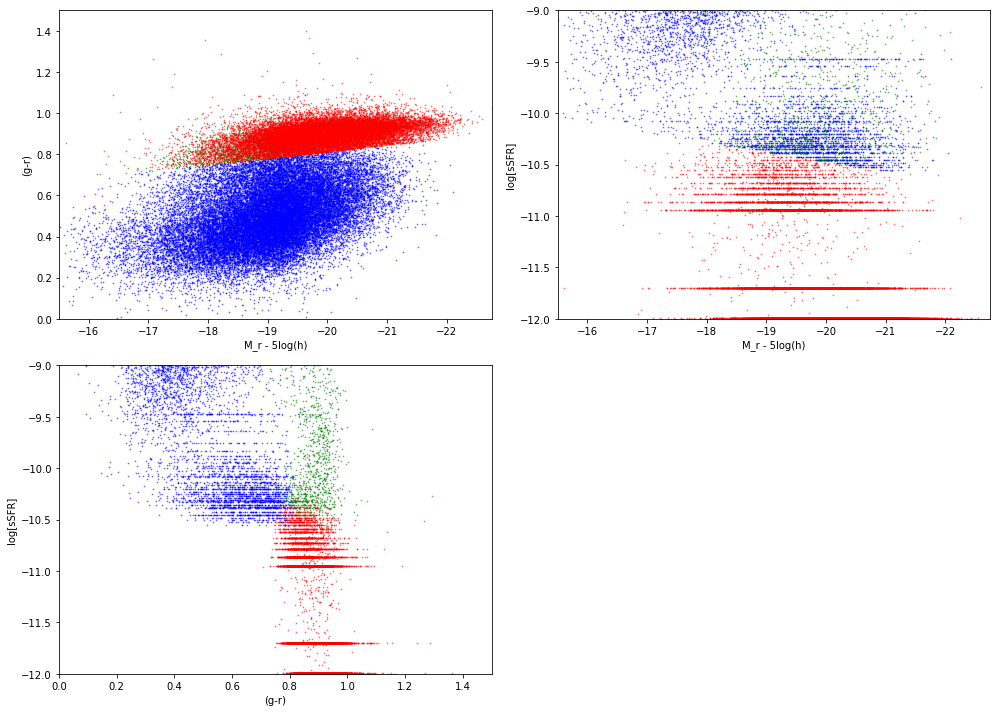

In [8]:
fig = plt.figure(figsize=(14,10))

colors = [late_color, int_color, early_color]
mrs = [late_mr, int_mr, early_mr]
sfrs = [late_sfr, int_sfr, early_sfr]
plot_color = ['b', 'g', 'r']

#top left plot
ax1 = fig.add_subplot(221)
for i in np.arange(3):
    ax1.scatter(mrs[i], colors[i], color = plot_color[i], s=0.5, alpha=0.5)
ax1.set_ylabel('(g-r)')
ax1.set_xlabel('M_r - 5log(h)')
ax1.set_ylim(0, 1.5)
ax1.set_xlim(-15.5, -22.75)

#top right plot
ax2 = fig.add_subplot(222)
for i in np.arange(3):
    ax2.scatter(mrs[i], sfrs[i], color = plot_color[i], s=0.5, alpha=0.5)
ax2.set_ylabel('log[sSFR]')
ax2.set_xlabel('M_r - 5log(h)')
ax2.set_ylim(-12, -9)
ax2.set_xlim(-15.5, -22.75)

#bottom left plot
ax3 = fig.add_subplot(223)
for i in np.arange(3):
    ax3.scatter(colors[i], sfrs[i], color = plot_color[i], s=0.5, alpha=0.5)
ax3.set_ylabel('log[sSFR]')
ax3.set_xlabel('(g-r)')
ax3.set_ylim(-12, -9)
ax3.set_xlim(0,1.5)

plt.tight_layout()
plt.show()

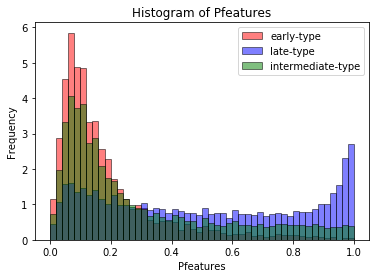

In [5]:
plt.hist(early_pfeatures, 50, normed=1, facecolor='r', alpha=0.5, ec='black', label='early-type')
plt.hist(late_pfeatures, 50, normed=1, facecolor='b', alpha=0.5, ec='black', label='late-type')
plt.hist(int_pfeatures, 50, normed=1, facecolor='g', alpha=0.5, ec='black', label='intermediate-type')
plt.xlabel('Pfeatures')
plt.ylabel('Frequency')
plt.title('Histogram of Pfeatures')
plt.legend(loc='upper right')
plt.show()

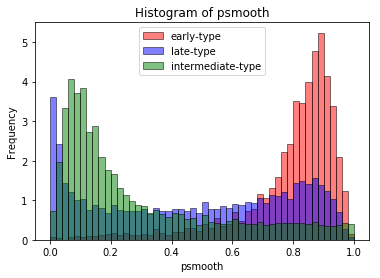

In [6]:
plt.hist(early_psmooth, 50, normed=1, facecolor='r', alpha=0.5, ec='black', label='early-type')
plt.hist(late_psmooth, 50, normed=1, facecolor='b', alpha=0.5, ec='black', label='late-type')
plt.hist(int_psmooth, 50, normed=1, facecolor='g', alpha=0.5, ec='black', label='intermediate-type')
plt.xlabel('psmooth')
plt.ylabel('Frequency')
plt.title('Histogram of psmooth')
plt.legend(loc='upper center')
plt.show()